# Model Tuning Action Plan
- Top 3 models by balanced accuracy: 
    - Logistic regression (internal "balanced" about equal with manual oversample) 95% +/- 1%
    - ExtraTrees classifier (subsample only, others not as good) 94.2% +/- 0.8%
    - SVC (manual subsample or oversample, internal "balanced" not as good) 94% +/- 1.3%
- Tune, then ROC/AUC for top 3
- Compare to DummyClassifier
- Run against test set for final validation
- sklearn "model stacking" (predictions uncorrelated, maybe a weak with a strong? Different types, linear/not/etc)

In [1]:
# import libraries and load data
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# scaling, sampling, and modeling tools
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# basic models for testing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier

df = pd.read_csv('data\creditcard.csv')

In [2]:
# Scale "amount" and "time" features to match remaining
std_scaler = StandardScaler()

df['std_scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['std_scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

In [3]:
# train/test split BEFORE under or over sampling
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# split Class balance evaluation
classcount = y_train.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Training Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))
classcount = y_test.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Test Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))
print("Original Data contains 492 fraudulent transactions which are 0.173% of all transactions") # calculated in data wrangling

Training Data contains 344 fraudulent transactions which are 0.173% of all transactions
Test Data contains 148 fraudulent transactions which are 0.173% of all transactions
Original Data contains 492 fraudulent transactions which are 0.173% of all transactions


In [4]:
# run dummy classifier with "stratified" (ie predict according to class balance) strategy for comparison
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)
# I don't know what kind of "score" this is producing. It doesn't seem to recognize "balanced accuracy" as an option.
# may need to produce ROC/AUC for best comparison.

0.9965942207085425

In [5]:
# Tuning Logistic Regression
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'class_weight':['balanced']}
logreg = LogisticRegression()
tuned_lr = GridSearchCV(logreg, grid_values, scoring="balanced_accuracy", return_train_score=True, n_jobs=-1)
tuned_lr.fit(X_train, y_train)
print(tuned_lr.best_params_)
print(tuned_lr.best_score_)

D:\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: 

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
0.9503746812064537


In [6]:
tuned_lr.score(X_test, y_test)

0.9287665383890251

So, maybe 95% balanced accuracy is not so good? Or do I get to use "balanced accuracy" scoring on the dummy classifier? What's up with the non-finite scores warning? Also, tuning is basically no better than default parameters.

In [7]:
# Tuning Extra Trees with subsample
subsample = RandomUnderSampler(random_state=42)
X_tr_sub, y_tr_sub = subsample.fit_resample(X_train, y_train) #grid search didn't work as a pipeline
extree = ExtraTreesClassifier() 
grid_values = {'n_estimators': [10, 100, 500, 1000], 'max_features': [1, 2, 5, 10, 'sqrt', 'log2'],
               'min_samples_split': [2, 4, 6, 8, 10], 'random_state': [42]}
tuned_ext = GridSearchCV(extree, grid_values, scoring="balanced_accuracy", return_train_score=True, n_jobs=-1)
tuned_ext.fit(X_tr_sub, y_tr_sub)
print(tuned_ext.best_params_)
print(tuned_ext.best_score_)

{'max_features': 10, 'min_samples_split': 6, 'n_estimators': 100, 'random_state': 42}
0.94192242114237


In [8]:
tuned_ext.score(X_test, y_test) # assuming I don't apply subsampling to test data...

0.918471267445416

Again, tuning is no better than defaults; running against test holdout is worse; and scores don't approach the dummy.

In [9]:
# Tuning SVC with subsample
svc = SVC()
grid_values = {'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10, 100],
               'C': [0.1, 1, 10, 100, 1000], 'random_state': [42]}
tuned_svc = GridSearchCV(svc, grid_values, scoring="balanced_accuracy", return_train_score=True, n_jobs=-1)
tuned_svc.fit(X_tr_sub, y_tr_sub)
print(tuned_svc.best_params_)
print(tuned_svc.best_score_)

{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 42}
0.9447996589940324


In [10]:
tuned_svc.score(X_test, y_test)

0.9300463177873928

Well, this one produced a ~0.005 improvement and its test score is at least closer to its train score.

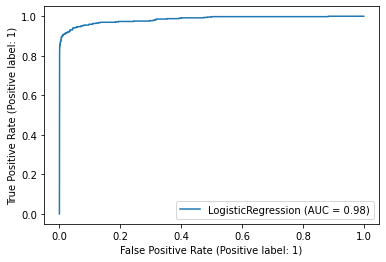

In [11]:
# note the display "from_estimator" requires version 1.0+ of sklearn
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(tuned_lr.best_estimator_, X, y)

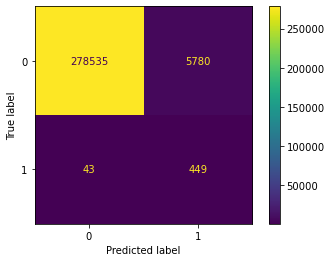

In [12]:
ConfusionMatrixDisplay.from_estimator(tuned_lr.best_estimator_, X, y)

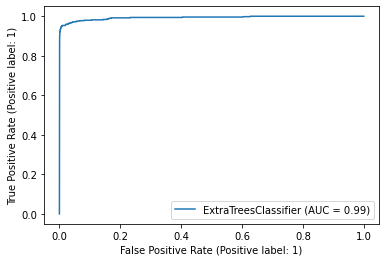

In [13]:
RocCurveDisplay.from_estimator(tuned_ext.best_estimator_, X, y)

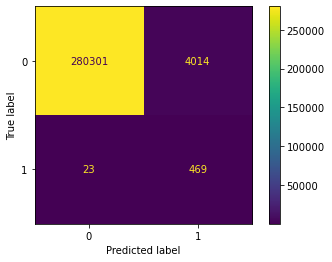

In [14]:
ConfusionMatrixDisplay.from_estimator(tuned_ext.best_estimator_, X, y)

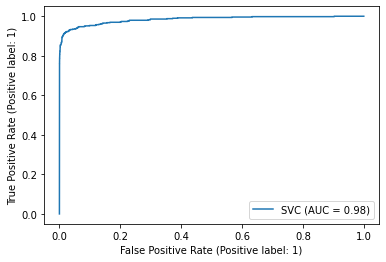

In [15]:
RocCurveDisplay.from_estimator(tuned_svc.best_estimator_, X, y)

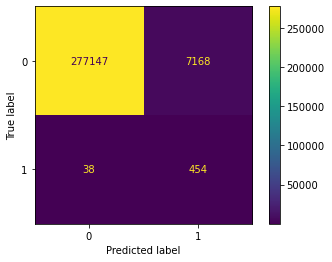

In [16]:
ConfusionMatrixDisplay.from_estimator(tuned_svc.best_estimator_, X, y)

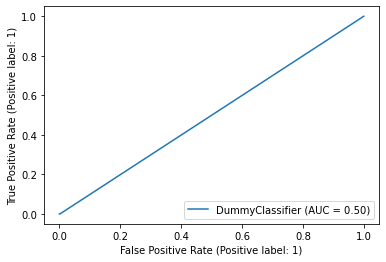

In [17]:
RocCurveDisplay.from_estimator(dummy, X, y)

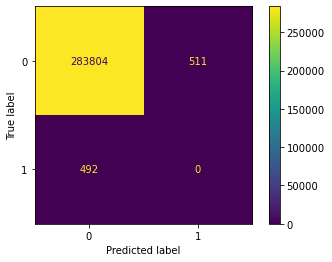

In [18]:
ConfusionMatrixDisplay.from_estimator(dummy, X, y)

Okay, that's really wierd. How does the dummy classifier give itself a "score" over 99% and have a 50% AUC score? Also, by the confusion matrix it is actually utterly wrong. It got no true positives, and even though it made some positive guesses they were all false positives.

### Stacking time!

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
estimators = [('xt', tuned_ext.best_estimator_),
              ('svc', tuned_svc.best_estimator_),
              ('knn', KNeighborsClassifier())]
stack = StackingClassifier(estimators=estimators, final_estimator=tuned_lr.best_estimator_, n_jobs=-1)
stack.fit(X_train, y_train)
stack.score(X_test, y_test)

0.9992860737567735

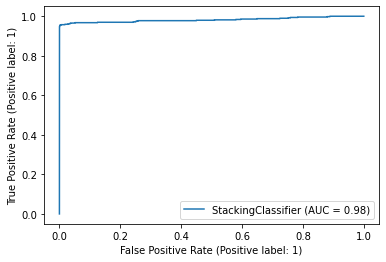

In [21]:
RocCurveDisplay.from_estimator(stack, X, y)

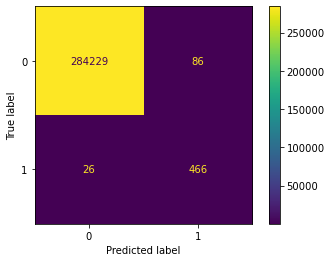

In [22]:
ConfusionMatrixDisplay.from_estimator(stack, X, y)

So, assuming my goals are to catch all the fraud we possibly can (maximize true positives; minimize false negatives), with the possible secondary goal of making as few extra "did you really authorize this charge?" phone calls as possible (minimize false positives), the stack comes out on top. It achieves 466 true positives with only 86 false negatives, where the individual estimators come close to the true positive rate but have thousands of false positives.